In [3]:
import simple_id
import torch
import os
import time
import gensim
import sys


from helpers import *

Previous work: [http://lstm.seas.harvard.edu/client/index.html](http://lstm.seas.harvard.edu/client/index.html)

Current interfaces:

[Word2Vec visual](http://shiny.reidmcy.com/int/)

[Records inspector](http://shiny.reidmcy.com/ntg/)

In [4]:
w2v = gensim.models.word2vec.Word2Vec.load('w2v/w2v.bin')
Net = torch.load(modelFname).cuda()

In [5]:
df_sample = pandas.read_csv('data/Other social sciences.csv', error_bad_lines = False)
df_sample.index = df_sample['wos_id']

In [6]:
row = df_sample.loc['WOS:000206783400002']

In [7]:
row_dict = dict(row)
row_dict['title_tokens'] = Tokens[row_dict['wos_id']][0]
row_dict['abstract_tokens'] = Tokens[row_dict['wos_id']][1]


row_dict['title_vecs'] = simple_id.genVecSeq(row_dict['title_tokens'], w2v)
row_dict['abstract_vecs'] = simple_id.genVecSeq(row_dict['abstract_tokens'], w2v)
row_dict['class'] = 1



In [8]:
predictionDict = Net.predictRow(row_dict)
predictionDict['wos_id'] = row['wos_id']
predictionDict['title'] = row['title']

In [9]:
predictionDict

{'weightP': tensor(1.1389, device='cuda:0'),
 'weightN': tensor(-0.9029, device='cuda:0'),
 'probPos': tensor(0.9645),
 'probNeg': tensor(0.1149),
 'prediction': 1,
 'wos_id': 'WOS:000206783400002',
 'title': 'An Agent-Based Spatially Explicit Epidemiological Model in MASON'}

(<Figure size 1440x1080 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10368da90>)

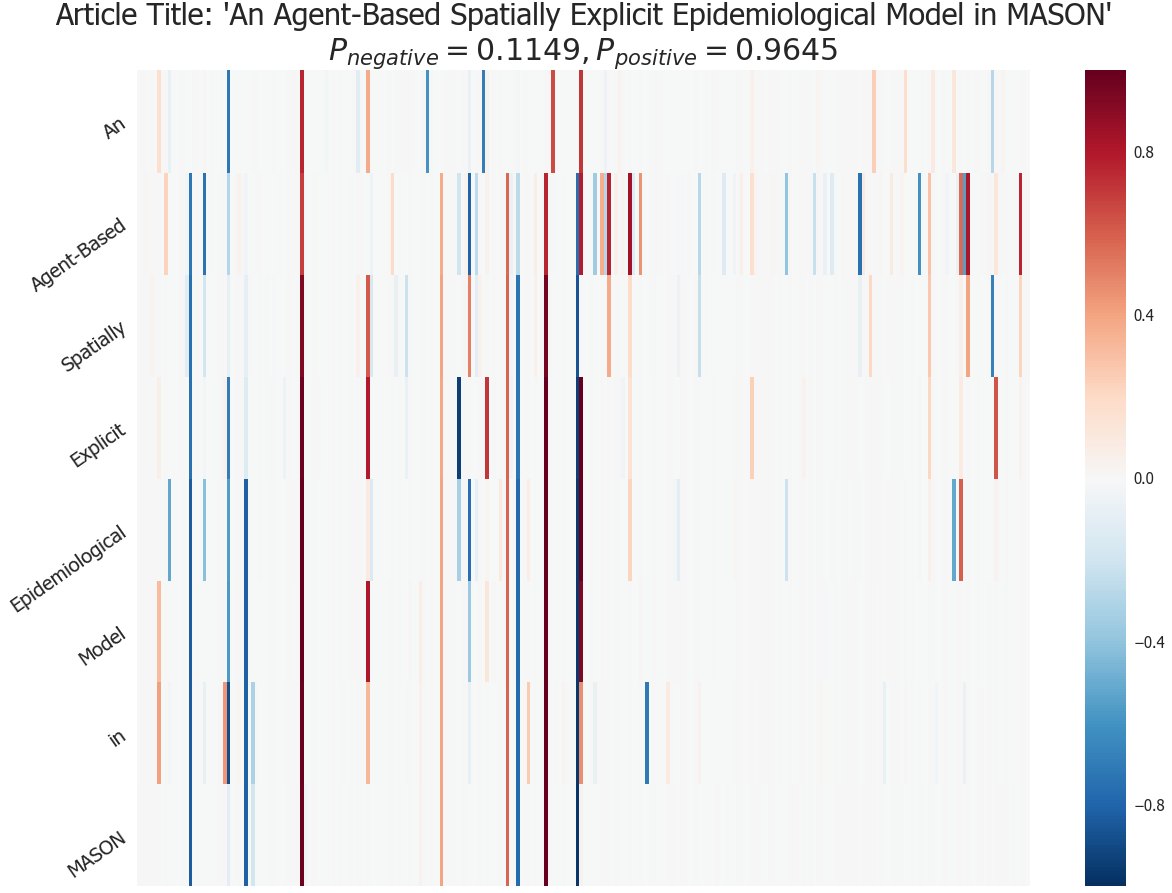

In [10]:
simple_id.compareRows([row_dict], Net)

In [11]:
row_dict['title_tokens']

['an',
 'agent-based',
 'spatially',
 'explicit',
 'epidemiological',
 'model',
 'in',
 'mason']

In [12]:
for i in range(len(row_dict['title_tokens'])):
    newDict = {
    'abstract' : row_dict['abstract'],
    'abstract_tokens' : row_dict['abstract_tokens'],
    #'title' : row_dict['title'],
    'title_tokens' : row_dict['title_tokens'][:i + 1],   
    }
    pred = Net.predictRow(newDict, w2v=w2v)
    print("propP is: {:.2f}% with title: '{}'".format(pred['probPos'] * 100, ' '.join(newDict['title_tokens'])))

propP is: 74.44% with title: 'an'
propP is: 97.52% with title: 'an agent-based'
propP is: 96.79% with title: 'an agent-based spatially'
propP is: 97.15% with title: 'an agent-based spatially explicit'
propP is: 96.01% with title: 'an agent-based spatially explicit epidemiological'
propP is: 96.46% with title: 'an agent-based spatially explicit epidemiological model'
propP is: 97.00% with title: 'an agent-based spatially explicit epidemiological model in'
propP is: 96.45% with title: 'an agent-based spatially explicit epidemiological model in mason'


In [13]:
for i in range(len(row_dict['abstract_tokens'])):
    newDict = {
    'abstract' : row_dict['abstract'],
    'abstract_tokens' : row_dict['abstract_tokens'][:i + 1],
    'title' : row_dict['title'],
    'title_tokens' : row_dict['title_tokens'],   
    }
    pred = Net.predictRow(newDict, w2v=w2v)
    print("propP is: {:.2f}% with abstract only {} sentences long".format(pred['probPos'] * 100, i + 1))

propP is: 95.96% with abstract only 1 sentences long
propP is: 95.39% with abstract only 2 sentences long
propP is: 94.61% with abstract only 3 sentences long
propP is: 96.45% with abstract only 4 sentences long


In [14]:
preds = []
for i in range(len(row_dict['title_tokens'])):
    predT = []
    for j in range(len(row_dict['abstract_tokens'])):
        newDict = {
            'abstract_tokens' : row_dict['abstract_tokens'][:j+1],
            'title_tokens' : row_dict['title_tokens'][:i + 1],   
            }
        #import pdb; pdb.set_trace()
        pred = Net.predictRow(newDict, w2v=w2v)
        predT.append(float(pred['probPos']))
    preds.append(predT)

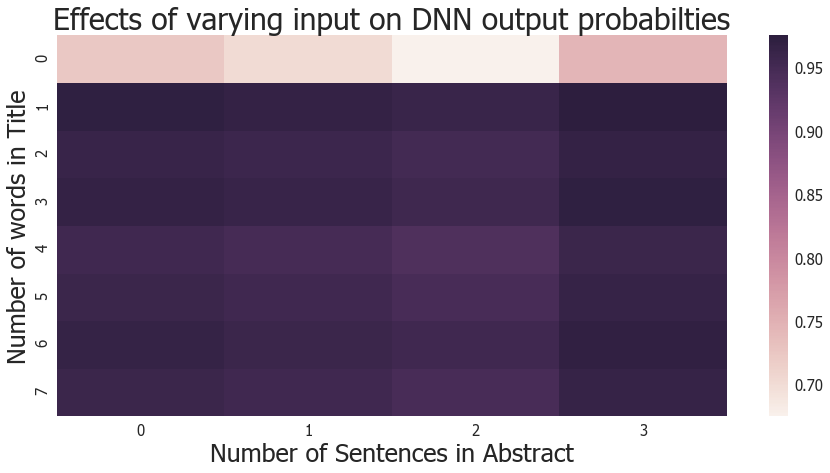

In [15]:
fig, ax = plt.subplots(figsize = (15, 7))
seaborn.heatmap(preds, ax = ax)
ax.set_ylabel('Number of Words in Title')
ax.set_xlabel('Number of Sentences in Abstract')
ax.set_title("Effects of varying input on DNN output probabilties");

In [36]:
preds = []
for i in range(len(row_dict['title_tokens'])):
    predT = []
    for j in range(len(row_dict['abstract_tokens'])):
        for k in range(len(row_dict['abstract_tokens'][j])):
            newDict = {
                'abstract_tokens' : row_dict['abstract_tokens'][:j] + [row_dict['abstract_tokens'][j][:k+1]],
                'title_tokens' : row_dict['title_tokens'][:i + 1],   
                }
            pred = Net.predictRow(newDict, w2v=w2v)
            predT.append(float(pred['probPos']))
    print("{:.0f}% done".format(i / len(row_dict['title_tokens']) * 100), end = '\r')
    preds.append(predT)

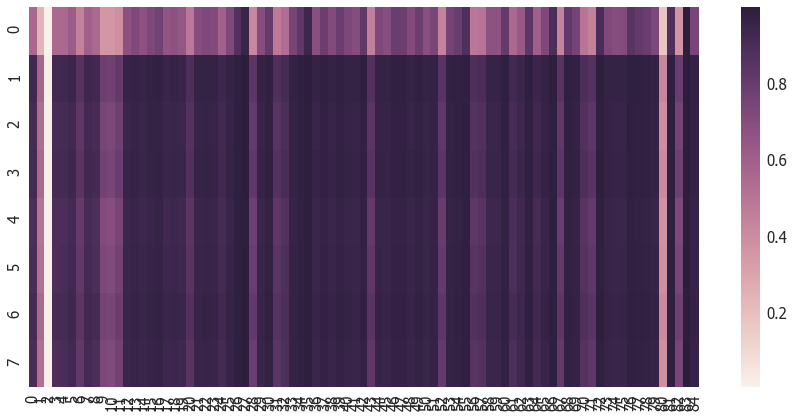

In [34]:
fig, ax = plt.subplots(figsize = (15, 7))
seaborn.heatmap(preds, ax = ax)
ax.set_ylabel('Number of Words in Title')
ax.set_xlabel('Number of Words in Abstract')
ax.set_title("Effects of varying Input on DNN output probabilties");

# Next steps

+ Get interface with R setup
+ Make interactive
+ Add real explanations
+ Maybe add more modes

Is it truthful?

Is it functional?

Is it beautiful?

Is it insightful?

Is it enlightening?